In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import joblib
from typing import Any
sys.path.insert(0, os.path.abspath('..'))

from src.feature_engineer import load_encoder
from src.utils.model_utils import evaulate_model, train_model
from src.utils.visualize_utils import plot_cm, get_avg_fold
from src.utils.math_utils import get_fft_power

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

from scipy.spatial.transform import Rotation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

In [3]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

# full_df = full_df.drop(columns=[col for col in full_df.columns if col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v61,tof_5_v62,tof_5_v63,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,-1.0,-1.0,71.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,-1.0,-1.0,-1.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,-1.0,-1.0,-1.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,-1.0,-1.0,-1.0,1,30,0,1,186.0,55,30.0


non_target_gestures = full_df[full_df["sequence_type"] == "Non-Target"]["gesture"].unique()
target_gestures = full_df[full_df["sequence_type"] == "Target"]["gesture"].unique()

filtered_df = full_df[full_df["phase"] == "Gesture"]
filtered_df.loc[filtered_df["sequence_type"] == "Non-Target", "gesture"] = non_target_gestures[0]

# drop the fucken kids
filtered_df = filtered_df[filtered_df['adult_child'] == 0]
# feature engineer rot_w r_x, rt_y rotz
# drop na
bad_seq_id = full_df[full_df["rot_w"].isnull()]["sequence_id"].unique()
bad_seq_mask = filtered_df["sequence_id"].isin(bad_seq_id)
filtered_df = filtered_df[~bad_seq_mask]
filtered_df["rot_w"].isnull().sum()


# rotation vector crafting
quat = filtered_df[["rot_w", "rot_x", "rot_y", "rot_z"]]
rotation_object = Rotation.from_quat(quat)
rotation_vectors = rotation_object.as_rotvec()

filtered_df["rotvec_x"] = rotation_vectors[:, 0]
filtered_df["rotvec_y"] = rotation_vectors[:, 1]
filtered_df["rotvec_z"] = rotation_vectors[:, 2]
filtered_df["rot_angle"] = np.linalg.norm(rotation_vectors, axis=1)

filtered_df["rotvec_x_diff"] = filtered_df.groupby("sequence_id")["rotvec_x"].transform(lambda x: x.diff().fillna(0))
filtered_df["rotvec_y_diff"] = filtered_df.groupby("sequence_id")["rotvec_y"].transform(lambda x: x.diff().fillna(0))
filtered_df["rotvec_z_diff"] = filtered_df.groupby("sequence_id")["rotvec_z"].transform(lambda x: x.diff().fillna(0))
filtered_df["angular_mag"] = np.linalg.norm([filtered_df["rotvec_x_diff"], filtered_df["rotvec_y_diff"], filtered_df["rotvec_z_diff"]], axis=0)

# Feature Engineer for Accelerometer
cols_of_interest = ["acc_x", "acc_y", "acc_z"]

for col in cols_of_interest:
    filtered_df[f"fft_{col}"] = filtered_df.groupby("sequence_id")[col].transform(get_fft_power)

filtered_df["acc_mag"] = np.linalg.norm([filtered_df["acc_x"], filtered_df["acc_y"], filtered_df["acc_z"]], axis=0)
filtered_df["jerk_acc_x"] = filtered_df.groupby("sequence_id")["acc_x"].diff().fillna(0)
filtered_df["jerk_acc_y"] = filtered_df.groupby("sequence_id")["acc_y"].diff().fillna(0)
filtered_df["jerk_acc_z"] = filtered_df.groupby("sequence_id")["acc_z"].diff().fillna(0)

filtered_df

In [5]:
bad_subjects = [
    [
        "SUBJ_052342",
        "SUBJ_024086",
        "SUBJ_019262",
        "SUBJ_058786",
        "SUBJ_032761",
        "SUBJ_064387",
        "SUBJ_036405",
        "SUBJ_038709",
    ],
    [
        "SUBJ_001430",
        "SUBJ_024137",
        "SUBJ_061552",
        "SUBJ_040106",
        "SUBJ_034631",
        "SUBJ_008728",
        "SUBJ_042254",
    ],
]
good_subjects = [
    [
        "SUBJ_032165",
        "SUBJ_063464",
        "SUBJ_034574",
        "SUBJ_054811",
        "SUBJ_017499",
        "SUBJ_038277",
        "SUBJ_053217",
        "SUBJ_043192",
    ],
    [
        "SUBJ_040733",
        "SUBJ_055211",
        "SUBJ_059330",
        "SUBJ_038023",
        "SUBJ_044680",
        "SUBJ_021670",
        "SUBJ_008304",
        "SUBJ_036450",
    ],
]


def label_group(x):
    if x in bad_subjects[0]:
        return "bad0"
    elif x in bad_subjects[1]:
        return "bad1"
    if x in good_subjects[0]:
        return "good0"
    elif x in good_subjects[1]:
        return "good1"
    else:
        return np.nan


filtered_df = full_df.copy()
filtered_df["group"] = filtered_df["subject"].apply(label_group)
filtered_df = filtered_df.dropna(subset="group")
filtered_df.columns

Index(['row_id', 'sequence_type', 'sequence_id', 'sequence_counter', 'subject',
       'orientation', 'behavior', 'phase', 'gesture', 'acc_x',
       ...
       'tof_5_v62', 'tof_5_v63', 'adult_child', 'age', 'sex', 'handedness',
       'height_cm', 'shoulder_to_wrist_cm', 'elbow_to_wrist_cm', 'group'],
      dtype='object', length=349)

In [ ]:
# filtered_df['gesture'].unique()

array(['Write name on leg', 'Forehead - pull hairline', 'Neck - scratch',
       'Eyebrow - pull hair', 'Above ear - pull hair',
       'Forehead - scratch', 'Neck - pinch skin', 'Cheek - pinch skin',
       'Eyelash - pull hair'], dtype=object)

<Axes: xlabel='group', ylabel='tof_5_v3'>

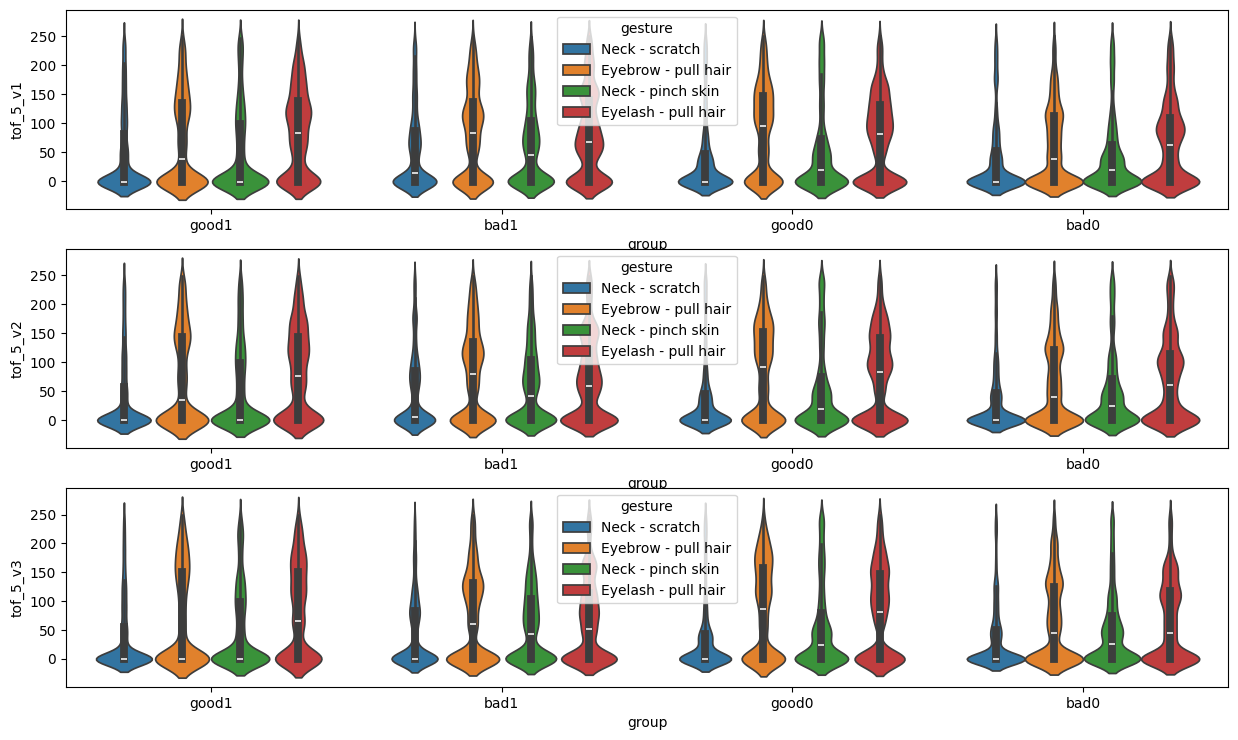

In [7]:
plt.figure(figsize=(15, 15))
plt.subplot(511)
target_gestures_mask = filtered_df["gesture"].isin(["Neck - scratch", "Neck - pinch skin", "Eyelash - pull hair", "Eyebrow - pull hair"])
sns.violinplot(filtered_df[target_gestures_mask], hue="gesture", x="group", y="tof_5_v1")
plt.subplot(512)
sns.violinplot(filtered_df[target_gestures_mask], hue="gesture", x="group", y="tof_5_v2")
plt.subplot(513)
sns.violinplot(filtered_df[target_gestures_mask], hue="gesture", x="group", y="tof_5_v3")

In [40]:
filtered_df.columns

Index(['row_id', 'sequence_type', 'sequence_id', 'sequence_counter', 'subject',
       'orientation', 'behavior', 'phase', 'gesture', 'acc_x', 'acc_y',
       'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3',
       'thm_4', 'thm_5', 'adult_child', 'age', 'sex', 'handedness',
       'height_cm', 'shoulder_to_wrist_cm', 'elbow_to_wrist_cm', 'group'],
      dtype='object')

<Axes: xlabel='group', ylabel='age'>

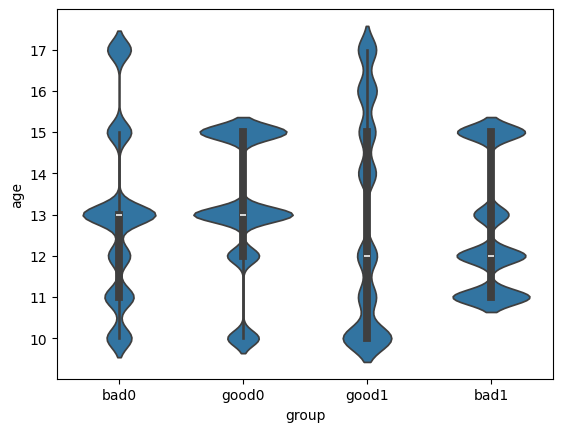

In [41]:
sns.violinplot(filtered_df, x='group', y='age')

bad outliers count:  nan %


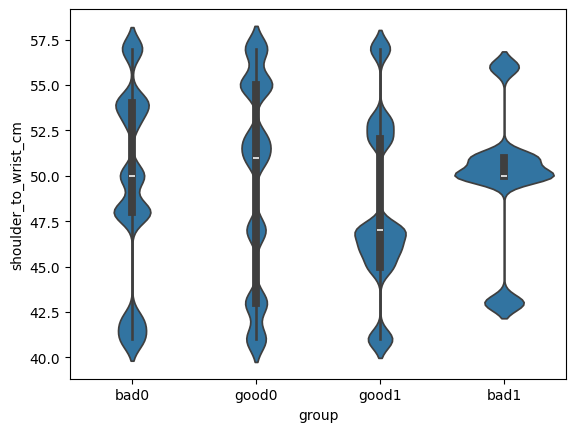

In [43]:
sns.violinplot(filtered_df, x='group', y='shoulder_to_wrist_cm')
print("bad outliers count: ", (filtered_df[filtered_df['group'] == 'bad']['shoulder_to_wrist_cm'] > 65).mean() * 100, "%")

bad outliers count:  nan %


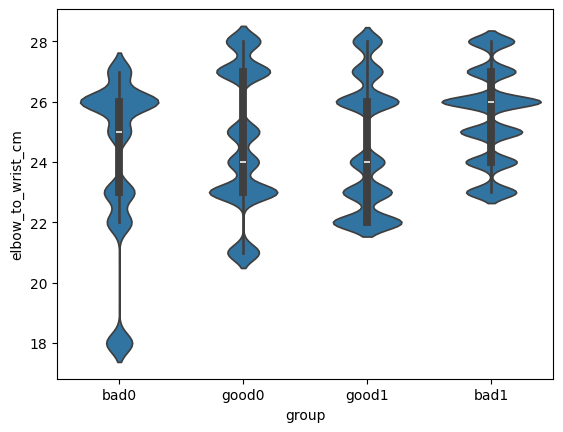

In [44]:
sns.violinplot(filtered_df, x='group', y='elbow_to_wrist_cm')
print("bad outliers count: ", (filtered_df[filtered_df['group'] == 'bad']['elbow_to_wrist_cm'] > 35).mean() * 100, "%")

<Axes: xlabel='adult_child', ylabel='Count'>

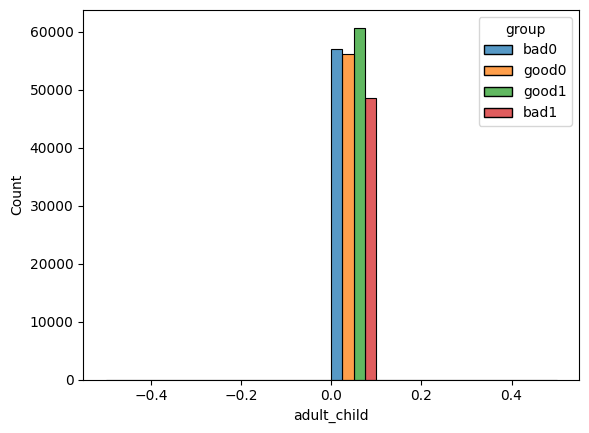

In [53]:
# sns.countplot(filtered_df, x='adult_child', hue='group')
sns.histplot(filtered_df, x='adult_child', hue='group', bins=10, multiple='dodge')

In [54]:
print("good adult_child=0: ", (filtered_df[filtered_df['group'] == 'good']['adult_child'] == 0).mean() * 100)
print("bad adult_child=0: ", (filtered_df[filtered_df['group'] == 'bad']['adult_child'] == 0).mean() * 100)

good adult_child=0:  nan
bad adult_child=0:  nan
